In [1]:
import json
from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor

# Load from JSON
with open("relaxed_structures_with_energies.json", "r") as f:
    data = json.load(f)

# Reconstruct formation_energies as a list of (ase.Atoms, formation_energy)
formation_energies = []
for entry in data:
    pmg_struct = Structure.from_dict(entry["structure"])
    atoms = AseAtomsAdaptor.get_atoms(pmg_struct)
    formation_energies.append((atoms, entry["formation_energy"]))

In [2]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np

lowest_by_comp = defaultdict(lambda: (None, np.inf))

for atoms, E_form in tqdm(formation_energies):
    formula = atoms.get_chemical_formula()
    if E_form < lowest_by_comp[formula][1]:
        lowest_by_comp[formula] = (atoms, E_form)

# print results
for formula, (atoms, E_form) in lowest_by_comp.items():
    print(f"{formula}: lowest formation energy = {E_form:.4f} eV/atom")

100%|██████████| 4764/4764 [00:00<00:00, 40503.98it/s]

NbW9: lowest formation energy = -0.0282 eV/atom
NbTaW8: lowest formation energy = -0.0623 eV/atom
NbTa2W7: lowest formation energy = -0.0827 eV/atom
NbTa3W6: lowest formation energy = -0.0895 eV/atom
NbTa4W5: lowest formation energy = -0.0882 eV/atom
NbTa5W4: lowest formation energy = -0.0799 eV/atom
NbTa6W3: lowest formation energy = -0.0638 eV/atom
NbTa7W2: lowest formation energy = -0.0442 eV/atom
NbTa8W: lowest formation energy = -0.0237 eV/atom
NbTa9: lowest formation energy = -0.0008 eV/atom


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import re

def tungsten_fraction(formula):
    match = re.search(r'W(\d*)', formula)
    if match:
        w_count = int(match.group(1)) if match.group(1) else 1
    else:
        w_count = 0
    counts = re.findall(r'([A-Z][a-z]*)(\d*)', formula)
    total = sum(int(n) if n else 1 for el, n in counts)
    return w_count / total if total > 0 else 0

# Gather all formation energies and tungsten fractions
all_fractions = []
all_energies = []

for atoms, E_form in formation_energies:
    formula = atoms.get_chemical_formula()
    frac = tungsten_fraction(formula)
    all_fractions.append(frac)
    all_energies.append(E_form)

all_fractions = np.array(all_fractions)
all_energies = np.array(all_energies)

# Get lowest formation energy for each composition
lowest_fractions = []
lowest_energies = []
for formula, (atoms, E_form) in lowest_by_comp.items():
    frac = tungsten_fraction(formula)
    lowest_fractions.append(frac)
    lowest_energies.append(E_form)
lowest_fractions = np.array(lowest_fractions)
lowest_energies = np.array(lowest_energies)
sort_idx = np.argsort(lowest_fractions)
lowest_fractions = lowest_fractions[sort_idx]
lowest_energies = lowest_energies[sort_idx]

In [38]:
from ase.constraints import FixSymmetry
from ase.optimize import FIRE
from typing import Union, Optional

from ase import Atoms
from ase.filters import Filter

def relax_atoms(
    atoms: Atoms,
    steps: int = 500,
    fmax: float = 0.02,
    optimizer_cls: Optional[None] = None,
    fix_symmetry: bool = False,
    cell_filter_cls: Optional[type[Filter]] = None,
) -> Atoms:
    """Simple helper function to run relaxations and return the relaxed Atoms

    Args:
        atoms: ASE atoms with a calculator
        steps: max number of relaxation steps
        fmax: force convergence threshold
        optimizer_cls: ASE optimizer. Default FIRE
        fix_symmetry: fix structure symmetry in relaxation: Default False
        cell_filter_cls: An instance of an ASE filter.

    Returns:
        Atoms: relaxed atoms
    """

    if fix_symmetry:
        atoms.set_constraint(FixSymmetry(atoms))

    if cell_filter_cls is not None:
        _atoms = cell_filter_cls(atoms)
    else:
        _atoms = atoms

    optimizer_cls = FIRE if optimizer_cls is None else optimizer_cls
    opt = optimizer_cls(_atoms, logfile=None)
    opt.run(fmax=fmax, steps=steps)

    atoms.info |= {"opt_nsteps": opt.nsteps}
    return atoms


from pymatgen.analysis.elasticity import DeformedStructureSet, ElasticTensor, Strain
from pymatgen.io.ase import AseAtomsAdaptor
from collections.abc import Sequence
from ase import Atoms
from ase.calculators.calculator import Calculator


def calculate_elasticity(
    atoms: Atoms,
    calculator: Calculator,
    norm_strains: Union[Sequence[float], float] = (-0.01, -0.005, 0.005, 0.01),
    shear_strains: Union[Sequence[float], float] = (-0.06, -0.03, 0.03, 0.06),
    relax_initial: bool = True,
    relax_strained: bool = True,
    use_equilibrium_stress: bool = True,
    **relax_kwargs,
):
    """Calculate elastic tensor, bulk, shear moduli following MP workflow

    Will not run a relaxation. We do that outside in order to be able to have more control.

    Args:
        atoms: ASE atoms object
        calculator: an ASE Calculator
        norm_strains: sequence of normal strains
        shear_strains: sequence of shear strains
        relax_initial: relax the initial structure. Default is True
        relax_strained: relax the atomic positions of strained structure. Default True.
        use_equilibrium_stress: use equilibrium stress in calculation. For relaxed structures this
            should be very small

    Returns:
        dict of elasticity results
    """
    atoms.calc = calculator
    if relax_initial:
        atoms = relax_atoms(atoms, **relax_kwargs)

    eq_stress = atoms.get_stress(voigt=False) if use_equilibrium_stress else None

    deformed_structure_set = DeformedStructureSet(
        AseAtomsAdaptor.get_structure(atoms),
        norm_strains,
        shear_strains,
    )

    strains = [
        Strain.from_deformation(deformation)
        for deformation in deformed_structure_set.deformations
    ]

    stresses = []
    for deformed_structure in deformed_structure_set:
        atoms = deformed_structure.to_ase_atoms()
        atoms.calc = calculator

        if relax_strained is True:
            relax_kwargs.update({"cell_filter_cls": None})
            atoms = relax_atoms(atoms, **relax_kwargs)

        stresses.append(atoms.get_stress(voigt=False))

    elastic_tensor = ElasticTensor.from_independent_strains(
        strains=strains, stresses=stresses, eq_stress=eq_stress
    )

    # results are in eV/A^3
    results = {
        "elastic_tensor": elastic_tensor,
        "shear_modulus_vrh": elastic_tensor.g_vrh,
        "bulk_modulus_vrh": elastic_tensor.k_vrh,
    }

    return results

In [52]:
from mace.calculators import MACECalculator
from ase.filters import FrechetCellFilter
from tqdm import tqdm
from ase.lattice.cubic import FaceCenteredCubic, BodyCenteredCubic
from mace.calculators import mace_mp
calc = MACECalculator(model_path='/Users/kareemabdelmaqsoud/Downloads/mace-omat-0-medium.model', device='cpu')
# calc = mace_mp(model="medium", dispersion=False, default_dtype="float32", device='cpu')

ev_to_gpa = 160.2176621
mlp_elastic_moduli = {}


for element in tqdm(["W", 'Ta', 'Nb']):
    atoms = BodyCenteredCubic(element)
    # Calculate elasticity
    results = calculate_elasticity(
        atoms,
        norm_strains=(-0.01, -0.005, 0.005, 0.01),
        shear_strains=(-0.06, -0.03, 0.03, 0.06),
        calculator=calc,
        cell_filter_cls=FrechetCellFilter,
        fix_symmetry=False,
        relax_initial=True,
        relax_strained=True,
    )
    
    # Convert to GPa
    shear_gpa = results['shear_modulus_vrh'] * ev_to_gpa
    bulk_gpa = results['bulk_modulus_vrh'] * ev_to_gpa
    pugh_ratio = shear_gpa / bulk_gpa
    
    # Store in dictionary
    mlp_elastic_moduli[element] = {
        'shear_modulus_vrh': shear_gpa,
        'bulk_modulus_vrh': bulk_gpa,
        'pugh_ratio': pugh_ratio,
    }
    print(f"{element}: Shear = {shear_gpa:.2f} GPa, Bulk = {bulk_gpa:.2f} GPa, Pugh Ratio = {pugh_ratio:.2f}")

Using head default out of ['default']
No dtype selected, switching to float64 to match model dtype.


 33%|███▎      | 1/3 [00:05<00:11,  5.82s/it]

W: Shear = 154.22 GPa, Bulk = 335.99 GPa, Pugh Ratio = 0.46


 67%|██████▋   | 2/3 [00:09<00:04,  4.75s/it]

Ta: Shear = 45.38 GPa, Bulk = 155.96 GPa, Pugh Ratio = 0.29


100%|██████████| 3/3 [00:14<00:00,  4.69s/it]

Nb: Shear = 43.90 GPa, Bulk = 158.34 GPa, Pugh Ratio = 0.28


In [47]:
import numpy as np
np.round(np.abs(results['elastic_tensor'].voigt*ev_to_gpa))

array([[293., 150., 150.,   0.,   0.,   0.],
       [150., 293., 150.,   0.,   0.,   0.],
       [150., 150., 293.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  45.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  45.,   0.],
       [  0.,   0.,   0.,   0.,   0.,  45.]])

In [48]:
tensor = results['elastic_tensor'].voigt*ev_to_gpa
(tensor[0][0]-tensor[1][2])/2

71.20838391232344

In [43]:
bulk_gpa/((tensor[0][0]-tensor[1][2])/2)

2.7778021038736296

In [17]:
from mace.calculators import MACECalculator
from ase.filters import FrechetCellFilter
from tqdm import tqdm
from mace.calculators import mace_mp
calc = MACECalculator(model_path='/Users/kareemabdelmaqsoud/Downloads/MACE-matpes-r2scan-omat-ft.model', device='cpu')
# calc = mace_mp(model="medium", dispersion=False, default_dtype="float32", device='cpu')

ev_to_gpa = 160.2176621
mlp_elastic_moduli = {}

for name, (atoms, E_form) in tqdm(lowest_by_comp.items()):
    # Calculate elasticity
    results = calculate_elasticity(
        atoms,
        calculator=calc,
        cell_filter_cls=FrechetCellFilter,
        fix_symmetry=False,
        relax_initial=True,
        relax_strained=True,
    )
    
    # Convert to GPa
    shear_gpa = results['shear_modulus_vrh'] * ev_to_gpa
    bulk_gpa = results['bulk_modulus_vrh'] * ev_to_gpa
    pugh_ratio = shear_gpa / bulk_gpa
    
    # Store in dictionary
    mlp_elastic_moduli[name] = {
        'shear_modulus_vrh': shear_gpa,
        'bulk_modulus_vrh': bulk_gpa,
        'pugh_ratio': pugh_ratio,
        'formation_energy': E_form
    }
    print(f"{name}: Shear = {shear_gpa:.2f} GPa, Bulk = {bulk_gpa:.2f} GPa, Pugh Ratio = {pugh_ratio:.2f}, Formation Energy = {E_form:.4f} eV/atom")

Using head default out of ['default']
No dtype selected, switching to float64 to match model dtype.


 10%|█         | 1/10 [00:42<06:21, 42.40s/it]

NbW9: Shear = 152.07 GPa, Bulk = 315.79 GPa, Pugh Ratio = 0.48, Formation Energy = -0.0282 eV/atom


 20%|██        | 2/10 [01:47<07:23, 55.46s/it]

NbTaW8: Shear = 136.16 GPa, Bulk = 300.70 GPa, Pugh Ratio = 0.45, Formation Energy = -0.0623 eV/atom


 30%|███       | 3/10 [02:49<06:50, 58.59s/it]

NbTa2W7: Shear = 124.70 GPa, Bulk = 286.19 GPa, Pugh Ratio = 0.44, Formation Energy = -0.0827 eV/atom


 40%|████      | 4/10 [03:45<05:44, 57.46s/it]

NbTa3W6: Shear = 110.12 GPa, Bulk = 271.16 GPa, Pugh Ratio = 0.41, Formation Energy = -0.0895 eV/atom


 50%|█████     | 5/10 [04:44<04:51, 58.20s/it]

NbTa4W5: Shear = 98.07 GPa, Bulk = 256.71 GPa, Pugh Ratio = 0.38, Formation Energy = -0.0882 eV/atom


 60%|██████    | 6/10 [05:31<03:37, 54.40s/it]

NbTa5W4: Shear = 87.19 GPa, Bulk = 247.42 GPa, Pugh Ratio = 0.35, Formation Energy = -0.0799 eV/atom


 70%|███████   | 7/10 [06:36<02:53, 57.82s/it]

NbTa6W3: Shear = 78.53 GPa, Bulk = 236.15 GPa, Pugh Ratio = 0.33, Formation Energy = -0.0638 eV/atom


 80%|████████  | 8/10 [08:04<02:14, 67.42s/it]

NbTa7W2: Shear = 70.34 GPa, Bulk = 222.89 GPa, Pugh Ratio = 0.32, Formation Energy = -0.0442 eV/atom


 90%|█████████ | 9/10 [09:36<01:15, 75.19s/it]

NbTa8W: Shear = 64.05 GPa, Bulk = 212.90 GPa, Pugh Ratio = 0.30, Formation Energy = -0.0237 eV/atom


100%|██████████| 10/10 [10:30<00:00, 63.01s/it]

NbTa9: Shear = 58.49 GPa, Bulk = 202.43 GPa, Pugh Ratio = 0.29, Formation Energy = -0.0008 eV/atom


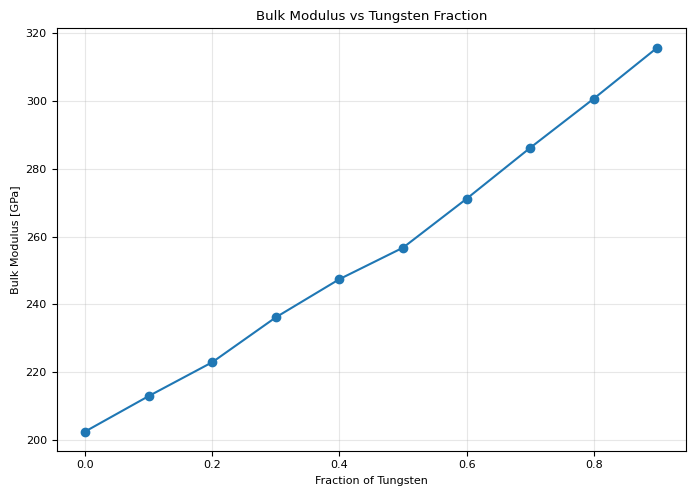

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import re

def tungsten_fraction(formula):
    # Extract number after 'W' (or 1 if just 'W')
    match = re.search(r'W(\d*)', formula)
    if match:
        w_count = int(match.group(1)) if match.group(1) else 1
    else:
        w_count = 0
    # Extract all element counts
    counts = re.findall(r'([A-Z][a-z]*)(\d*)', formula)
    total = sum(int(n) if n else 1 for el, n in counts)
    return w_count / total if total > 0 else 0

# Prepare data for plotting
fractions = np.array([tungsten_fraction(k) for k in mlp_elastic_moduli.keys()])
bulk_modulus = np.array([v['bulk_modulus_vrh'] for v in mlp_elastic_moduli.values()])
shear_modulus = np.array([v['shear_modulus_vrh'] for v in mlp_elastic_moduli.values()])
pugh_ratio = np.array([v['pugh_ratio'] for v in mlp_elastic_moduli.values()])

# Sort by fraction
sort_idx = np.argsort(fractions)
fractions = fractions[sort_idx]
bulk_modulus = bulk_modulus[sort_idx]
shear_modulus = shear_modulus[sort_idx]
pugh_ratio = pugh_ratio[sort_idx]

# Plot Bulk modulus
plt.figure(figsize=(7,5))
plt.plot(fractions, bulk_modulus, marker='o', label='Bulk modulus (VRH)')
plt.xlabel('Fraction of Tungsten')
plt.ylabel('Bulk Modulus [GPa]')
plt.title('Bulk Modulus vs Tungsten Fraction')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

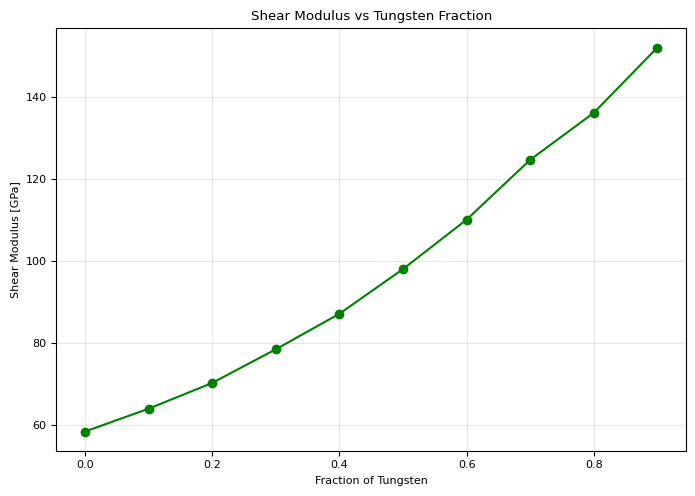

In [19]:
# Plot Shear modulus vs Tungsten fraction
plt.figure(figsize=(7,5))
plt.plot(fractions, shear_modulus, marker='o', color='green', label='Shear modulus (VRH)')
plt.xlabel('Fraction of Tungsten')
plt.ylabel('Shear Modulus [GPa]')
plt.title('Shear Modulus vs Tungsten Fraction')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

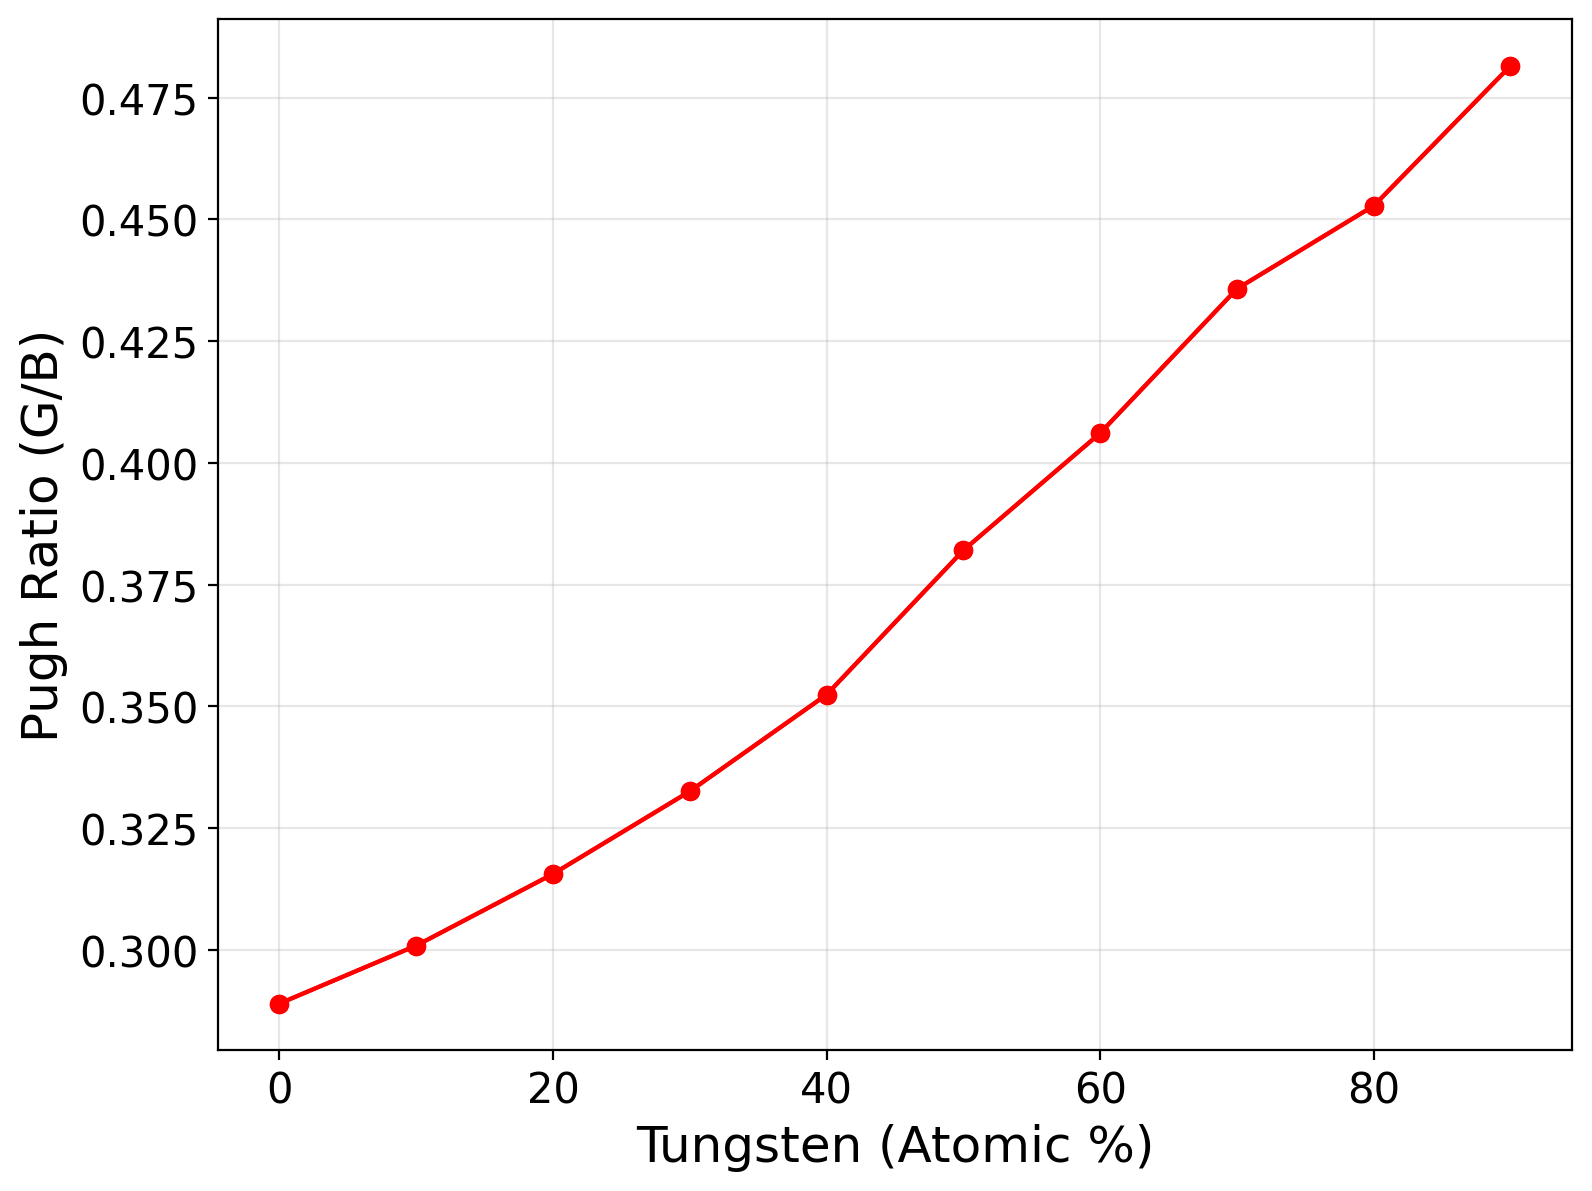

In [20]:
# Plot Pugh ratio vs Tungsten fraction
plt.figure(figsize=(8,6), dpi=200)
plt.plot(np.array(fractions)*100, pugh_ratio, marker='o', color='red', label='Pugh ratio')
# Add pure W as a red point and connect with a line
plt.plot(
    np.array(fractions)*100, pugh_ratio, 'o-', color='red'
)
plt.xlabel('Tungsten (Atomic %)', fontsize=18)
plt.ylabel('Pugh Ratio (G/B)', fontsize=18)
# plt.title('Pugh Ratio vs Tungsten Fraction', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()